# Robust Heteroskedastic Matrix Factorization
A robust-PCA-like model that knows about observational uncertainties

## Author:
- **David W. Hogg** (NYU) (MPIA) (Flatiron)
- (with help from Claude)

## Dependencies:
- `pip3 install jax matplotlib astropy astroquery`

## Issues:
- Assumes rectangular data with known uncertainties.

In [1]:
# jax related
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# data-gathering and plotting related
import numpy as np
import matplotlib.pyplot as plt
import clod
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

/Users/dhogg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
params = {
    'teff_min': 8000,
    'teff_max': 10000,
    'logg_min': 1.0,
    'logg_max': 5.0,
    'grvs_mag_max': 11.0,
    'n_sources': 200
}
sources = clod.find_rvs_sources_gspphot(**params)

INFO: Query finished. [astroquery.utils.tap.core]

Found 200 sources matching criteria


In [4]:
spectra_data = clod.download_multiple_spectra(sources, max_spectra=params['n_sources'])


Progress: 0/200 spectra processed...
Progress: 10/200 spectra processed...
Progress: 20/200 spectra processed...
Progress: 30/200 spectra processed...
Progress: 40/200 spectra processed...
Progress: 50/200 spectra processed...
Progress: 60/200 spectra processed...
Progress: 70/200 spectra processed...
Progress: 80/200 spectra processed...
Progress: 90/200 spectra processed...
Progress: 100/200 spectra processed...
Progress: 110/200 spectra processed...
Progress: 120/200 spectra processed...
Progress: 130/200 spectra processed...
Progress: 140/200 spectra processed...
Progress: 150/200 spectra processed...
Progress: 160/200 spectra processed...
Progress: 170/200 spectra processed...
Progress: 180/200 spectra processed...
Progress: 190/200 spectra processed...

Successfully downloaded 200 spectra


In [5]:
Y, wavelength_grid, source_ids, W = clod.create_spectral_matrices(spectra_data)
print(f"\nSpectral matrix statistics:")
print(f"  Min flux: {np.min(Y):.4f}")
print(f"  Max flux: {np.max(Y):.4f}")
print(f"  Mean flux: {np.mean(Y):.4f}")
print(f"  Std flux: {np.std(Y):.4f}")
print(f"  Mean invvar: {np.nanmean(W):.4f}")
print(f"  Contains NaN: {np.any(np.isnan(Y))}")
print(f"  Contains Inf: {np.any(np.isinf(Y))}")


Bad pixel statistics:
  Spectra with bad pixels: 138/200
  Total bad pixels: 679
  Bad pixels replaced with: 1.0

Spectral matrix statistics:
  Min flux: 0.4340
  Max flux: 1.0419
  Mean flux: 0.9523
  Std flux: 0.0610
  Mean invvar: 212585.2829
  Contains NaN: False
  Contains Inf: False


In [6]:
class RHMF():
    def __init__(self, rank, nsigma):
        self.K = int(rank)
        self.nsigma = float(nsigma)
        self.Q2 = self.nsigma ** 2

    def fit(self, data, weights):
        """
        # inputs:
        `data`:     (N, M) array of observations.
        `weights`:  units of (and equivalent to) inverse uncertainty variances.
        """
        assert np.sum(jnp.isnan(data)) == 0
        assert np.sum(jnp.isnan(weights)) == 0
        self.Y = jnp.array(data)
        self.input_W = jnp.array(weights)
        assert self.Y.shape == self.input_W.shape
        self.N, self.M = self.Y.shape
        self.converged = False
        self.n_iter = 0
        self._initialize()
        print("fit(): before starting:", self.objective(), self.original_objective())
        while not self.converged:
            print("fit(): before A-step:", self.objective(), self.original_objective())
            self._A_step()
            print("fit(): before G-step:", self.objective(), self.original_objective())
            self._G_step()
            print("fit(): before affine step:", self.objective(), self.original_objective())
            self._affine()
            print("fit(): before weight update step:", self.objective(), self.original_objective())
            self._update_W()
            print("fit(): after weight update step:", self.objective(), self.original_objective())
            self.n_iter += 1

    def _initialize(self):
        """
        # bugs:
        - Consider switching SVD to a fast PCA implementation?
        """
        self.W = 1. * self.input_W # copy not reference
        u, s, v = jnp.linalg.svd(Y, full_matrices=False) # maybe slow
        self.A = (u[:,:self.K] * s[:self.K]).T
        self.G = v[:self.K,:]
        print("_initialize():", self.A.shape, self.G.shape)

    def _one_star_A_step(self, i):
        XTCinvX = self.G * self.W[i] @ self.G.T
        XTCinvY = self.G * self.W[i] @ self.Y[i]
        return jnp.linalg.solve(XTCinvX, XTCinvY)

    def _one_star_G_step(self, j):
        XTCinvX = self.A * self.W[:,j] @ self.A.T
        XTCinvY = self.A * self.W[:,j] @ self.Y[:,j]
        return jnp.linalg.solve(XTCinvX, XTCinvY)

    def _A_step(self):
        self.A = jax.vmap(self._one_star_A_step)(jnp.arange(self.N)).T

    def _G_step(self):
        foo = self.objective()
        self.G = jax.vmap(self._one_star_G_step)(jnp.arange(self.M)).T
        bar = self.objective()
        if foo < bar:
            print("_G_step(): ERROR: objective got worse", foo, bar)
        if foo - bar < 1.e-2: # magic
            self.converged = True

    def _affine(self):
        """
        # bugs:
        - Consider switching SVD to a fast PCA implementation?
        """
        u, s, v = jnp.linalg.svd(self.A.T @ self.G, full_matrices=False)
        self.A = (u[:,:self.K] * s[:self.K]).T
        self.G = v[:self.K,:]

    def synthesis(self):
        return self.A.T @ self.G

    def resid(self):
        return self.Y - self.synthesis()

    def objective(self):
        return jnp.sum(self.W * self.resid() ** 2)

    def original_chi(self):
        return self.resid() * jnp.sqrt(self.input_W)

    def original_objective(self):
        return jnp.sum(self.input_W * self.resid() ** 2)

    def _update_W(self):
        self.W = self.input_W * self.Q2 / (self.input_W * self.resid() ** 2 + self.Q2)

In [7]:
model = RHMF(10, 2.5)
model.fit(Y, W)

_initialize(): (10, 200) (10, 2401)
fit(): before starting: 1195407.6963205403 1195407.6963205403
fit(): before A-step: 1195407.6963205403 1195407.6963205403
fit(): before G-step: 1181543.0156133375 1181543.0156133375
fit(): before affine step: 1095833.4090172718 1095833.4090172718
fit(): before weight update step: 1095833.4090172679 1095833.4090172679
fit(): after weight update step: 504763.5989340705 1095833.4090172679
fit(): before A-step: 504763.5989340705 1095833.4090172679
fit(): before G-step: 497652.5426122886 1099041.3319535765
fit(): before affine step: 488394.3544395121 1127136.0201842065
fit(): before weight update step: 488394.35443951195 1127136.0201842189
fit(): after weight update step: 484990.25370695617 1127136.0201842189
fit(): before A-step: 484990.25370695617 1127136.0201842189
fit(): before G-step: 483308.9489860459 1137987.2235879689
fit(): before affine step: 481058.7658235354 1164831.844802543
fit(): before weight update step: 481058.76582353574 1164831.8448025

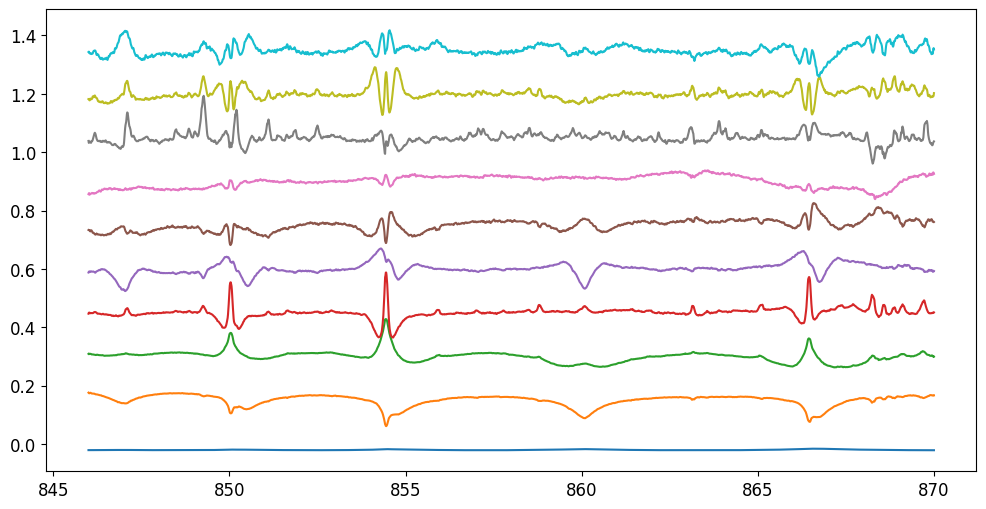

In [8]:
for k, g in enumerate(model.G):
    plt.plot(wavelength_grid, g + 0.15 * k)

In [9]:
chi = model.original_chi()
chi_squared = np.sum(chi ** 2, axis=1)
indx = np.argsort(chi_squared)
print(chi.shape, indx.shape)

(200, 2401) (200,)


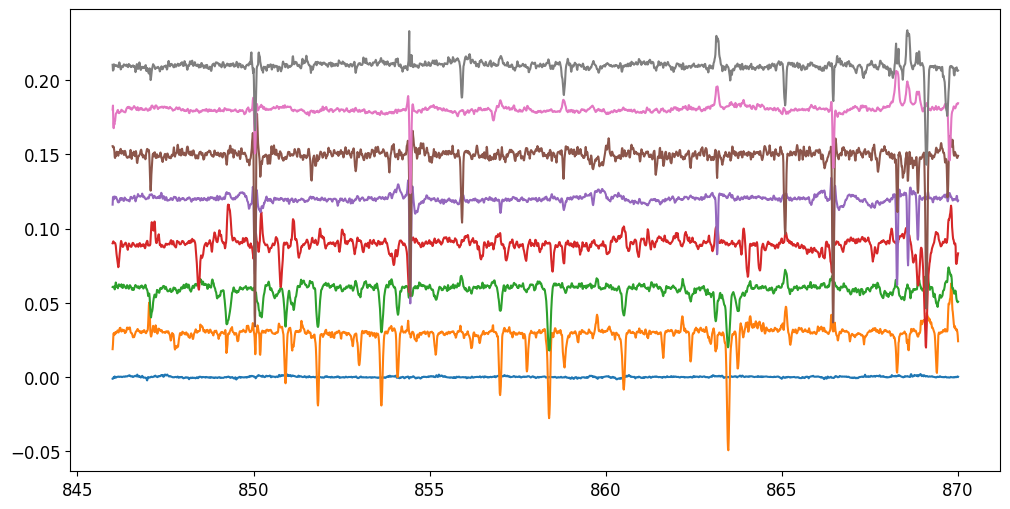

In [10]:
resid = model.resid()
for i in range(8):
    plt.plot(wavelength_grid, resid[indx[-i]] + 0.03 * i)